# Final Project: Predicting Storm Damage 
### Data Science 1: CS 109A/STAT 121A/AC 209A/ E 109A <br> Instructors: Pavlos Protopapas, Kevin Rader, Rahul Dave
#### Harvard University <br> Fall 2017 <br> 

---


In [4]:
import pandas as pd
import sys
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA

from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display
from matplotlib import colors

import copy
%matplotlib inline

In [6]:
df_orig = pd.read_csv('Storm_events_details_2016.csv')

df_orig.head()

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,...,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE
0,201607,15,1715,201607,15,1715,108769,651823,SOUTH CAROLINA,45,...,1.0,N,BOYD HILL,34.94,-81.03,34.94,-81.03,Scattered thunderstorms developed across the U...,One to two feet of deep standing water develop...,CSV
1,201607,15,1725,201607,15,1725,108769,651825,SOUTH CAROLINA,45,...,1.0,S,FT MILL,35.01,-80.93,35.01,-80.93,Scattered thunderstorms developed across the U...,NWS Columbia relayed a report of trees blown d...,CSV
2,201607,16,1246,201607,16,1246,108812,651828,NORTH CAROLINA,37,...,2.0,ENE,OLD FT,35.64,-82.14,35.64,-82.14,Scattered thunderstorms developed near the Blu...,Media reported two trees blown down along I-40...,CSV
3,201607,8,1755,201607,8,1755,105872,635287,TENNESSEE,47,...,1.0,W,JENA,35.65,-84.18,35.65,-84.18,The combination of summer heating and high low...,Numerous trees were reported down in the Green...,CSV
4,201607,8,1810,201607,8,1810,105872,635296,TENNESSEE,47,...,1.0,WSW,PITNER,35.87,-83.77,35.87,-83.77,The combination of summer heating and high low...,Numerous trees were reported down in Seymour. ...,CSV


In [7]:
df_orig.columns

Index(['BEGIN_YEARMONTH', 'BEGIN_DAY', 'BEGIN_TIME', 'END_YEARMONTH',
       'END_DAY', 'END_TIME', 'EPISODE_ID', 'EVENT_ID', 'STATE', 'STATE_FIPS',
       'YEAR', 'MONTH_NAME', 'EVENT_TYPE', 'CZ_TYPE', 'CZ_FIPS', 'CZ_NAME',
       'WFO', 'BEGIN_DATE_TIME', 'CZ_TIMEZONE', 'END_DATE_TIME',
       'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT',
       'DEATHS_INDIRECT', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'SOURCE',
       'MAGNITUDE', 'MAGNITUDE_TYPE', 'FLOOD_CAUSE', 'CATEGORY', 'TOR_F_SCALE',
       'TOR_LENGTH', 'TOR_WIDTH', 'TOR_OTHER_WFO', 'TOR_OTHER_CZ_STATE',
       'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_CZ_NAME', 'BEGIN_RANGE',
       'BEGIN_AZIMUTH', 'BEGIN_LOCATION', 'END_RANGE', 'END_AZIMUTH',
       'END_LOCATION', 'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON',
       'EPISODE_NARRATIVE', 'EVENT_NARRATIVE', 'DATA_SOURCE'],
      dtype='object')

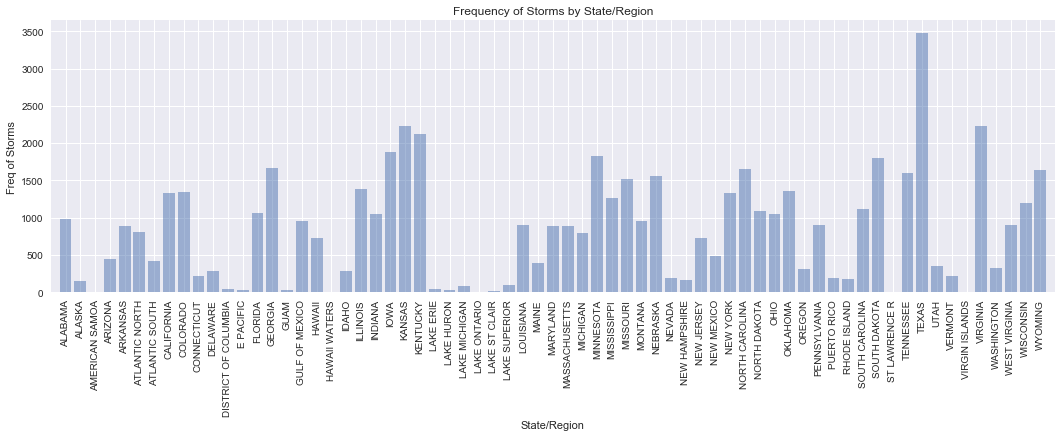

In [8]:
import seaborn as sns
sns.set(color_codes=True)
storm_counts_loc = np.unique(df_orig['STATE'], return_counts=True)

# plot this info
fig, ax = plt.subplots(1, 1, figsize=(18, 5))

ax.bar(range(67), storm_counts_loc[1], align='center', alpha=0.5)
ax.set_xlim([-1, 67])
ax.set_xticks(range(67))
ax.set_xticklabels(storm_counts_loc[0], rotation=90)
ax.set_xlabel('State/Region')
ax.set_ylabel('Freq of Storms')
ax.set_title('Frequency of Storms by State/Region')

plt.show()

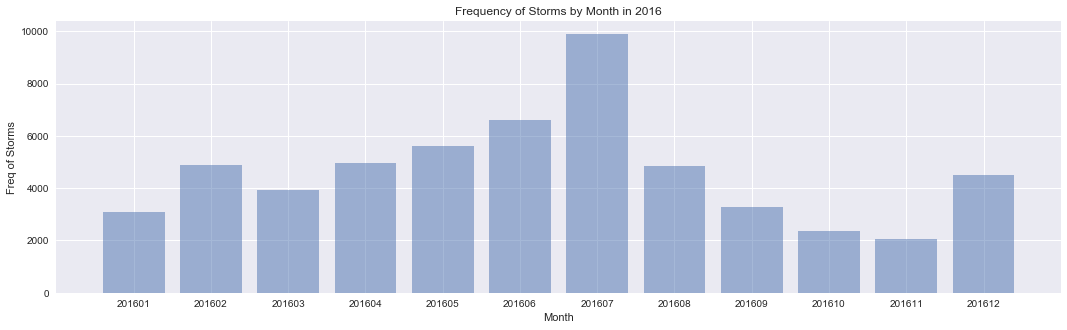

In [9]:
storm_counts_mo = np.unique(df_orig['BEGIN_YEARMONTH'], return_counts=True)

# plot this info
fig, ax = plt.subplots(1, 1, figsize=(18, 5))

ax.bar(range(12), storm_counts_mo[1], align='center', alpha=0.5)
ax.set_xlim([-1, 12])
ax.set_xticks(range(12))
ax.set_xticklabels(storm_counts_mo[0], rotation=0)
ax.set_xlabel('Month')
ax.set_ylabel('Freq of Storms')
ax.set_title('Frequency of Storms by Month in 2016')

plt.show()

## Data Processing: converted object to floats using regexp

In [10]:
df_orig["DAMAGE_PROPERTY"] = df_orig["DAMAGE_PROPERTY"].fillna(value="0")

In [11]:
import re
regexp1 = "(.*\..*)K"
regexp2 = "(.*\..*)M"
regexp3 = "(.*\..*)B"
damage_property = []
for i in df_orig["DAMAGE_PROPERTY"]:
    x1 = re.match(regexp1,i)
    x2 = re.match(regexp2,i)
    x3 = re.match(regexp3,i)
    if x1:
        damage_property.append(float(x1[1])*1000.)
    elif x2:
        damage_property.append(float(x2[1])*1000000.)
    elif x3:
        damage_property.append(float(x3[1])*1000000000.)
    else:
        damage_property.append(float(i))

In [12]:
df_orig["DAMAGE_PROPERTY"] = pd.Series(damage_property)

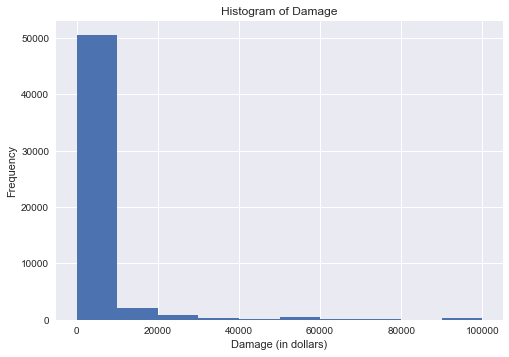

In [13]:
plt.hist(x=df_orig.DAMAGE_PROPERTY[df_orig.DAMAGE_PROPERTY <= 100000])
plt.xlabel("Damage (in dollars)")
plt.ylabel("Frequency")
plt.title("Histogram of Damage")

In [14]:
np.corrcoef(df_orig["DAMAGE_PROPERTY"],df_orig["DEATHS_DIRECT"])

array([[ 1.        ,  0.09034124],
       [ 0.09034124,  1.        ]])

Validation of our damage estimates.

In [15]:
df_orig.DAMAGE_PROPERTY[df_orig.DAMAGE_PROPERTY > 100000].shape

(1043,)

In [16]:
import scipy.stats as ss
print("Mean: {}".format(round(np.mean(df_orig.DAMAGE_PROPERTY)),4))
print("Median: {}".format(np.median(df_orig.DAMAGE_PROPERTY)))
print("Skew: {}".format(round(ss.skew(df_orig.DAMAGE_PROPERTY),2)))

Mean: 325547
Median: 0.0
Skew: 86.52


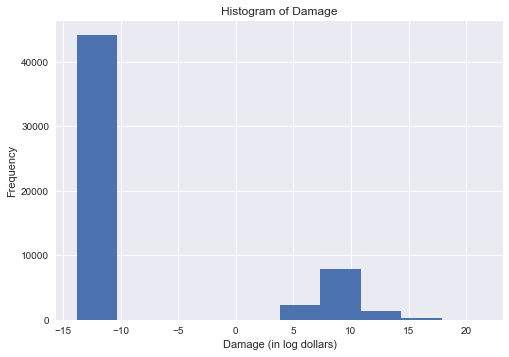

In [17]:
plt.hist(x=np.log(df_orig.DAMAGE_PROPERTY + .000001))
plt.xlabel("Damage (in log dollars)")
plt.ylabel("Frequency")
plt.title("Histogram of Damage")

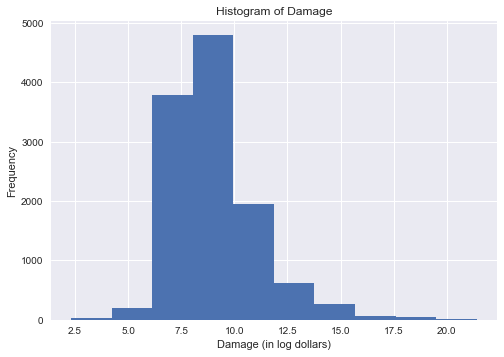

In [18]:
plt.hist(x=np.log(df_orig.DAMAGE_PROPERTY[df_orig.DAMAGE_PROPERTY>0] + .000001))
plt.xlabel("Damage (in log dollars)")
plt.ylabel("Frequency")
plt.title("Histogram of Damage")

## Mapping

In [19]:
import mpl_toolkits
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
 
map = Basemap(projection='merc', lat_0 = 57, lon_0 = -135,
    resolution = 'h', area_thresh = 0.1,
    llcrnrlon=-136.25, llcrnrlat=56.0,
    urcrnrlon=-134.25, urcrnrlat=57.75)

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'